# IMPORTS

In [2]:
import torch
import torch.nn as nn
from pymonntorch import Behavior, SynapseGroup, Network, NeuronGroup, Recorder, EventRecorder
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express
import numpy as np
from matplotlib.pyplot import  Button, Slider

# Izhikevich initialization and firing

In [3]:
class Izhikevich(Behavior):
    
    def initialize(self, neurons):
        super().initialize(neurons)
        self.add_tag("Izhikevich")
        self.set_parameters_as_variables(neurons)
        neurons.a *= neurons.vector('ones')
        neurons.b *= neurons.vector('ones')
        neurons.c *= neurons.vector('ones')
        neurons.d *= neurons.vector('ones')
        neurons.v = neurons.vector(mode="ones") * neurons.v_rest
        neurons.I = neurons.vector(mode="zeros")
        neurons.spikes = neurons.vector(mode="zeros")
        neurons.membrane_recovery = neurons.vector(mode="ones") * neurons.u
        
    def _dv_dt(self, neurons):
        # quad = torch.pow(neurons.v, 2)
        # print(neurons.I)
        res = neurons.dt * (0.04 * neurons.v**2 + 5*neurons.v + 140 - neurons.membrane_recovery + neurons.I)
        return res
    
    def _du_dt(self, neurons):
        return neurons.dt * (neurons.a * (neurons.b * neurons.v - neurons.membrane_recovery))
    
    def _fire(self, neurons):
        # neurons.spikes = neurons.v >= 30.
        neurons.v[neurons.spikes] = neurons.c[neurons.spikes]
        neurons.membrane_recovery[neurons.spikes] += neurons.d[neurons.spikes]
        
    def forward(self, neurons):
        # neurons.I = neurons.E_I[neurons.iteration-1]
        neurons.spikes = neurons.v >= 30.
        if torch.sum(neurons.spikes) > 0:
            self._fire(neurons)
        # self._fire(neurons)
        neurons.v += self._dv_dt(neurons) #* neurons.dt
        neurons.membrane_recovery += self._du_dt(neurons) #* neurons.dt
        
        # return neurons.v

# Izhikevich updating current and construct weights

In [4]:
class Izhikevich_input(Behavior):              

    def initialize(self, neurons):
        super().initialize(neurons)
        for synapse in neurons.afferent_synapses['All']:
            synapse.W = synapse.matrix(mode='uniform')
            # print(synapse.W)
            synapse.enabled = synapse.W > 0
    
    def _get_spikes(self, synapse):
        spikes = synapse.src.spikes.float()
        # print(spikes)
        return torch.matmul(synapse.W, spikes)

    def forward(self, neurons):
        neurons.I = neurons.E_I[neurons.iteration-1]
        for synapse in neurons.afferent_synapses['GLUTAMATE']: 
            # print(self._get_spikes(synapse))
            # print(synapse.src.size)
            neurons.I += 0.5*(self._get_spikes(synapse) / synapse.src.size )

In [6]:
EXC_SIZE = 1
INH_SIZE = EXC_SIZE // 4
ITER = 1000
torch.manual_seed(42)
MEAN_I = 20.
STD_I = 3.
I_EXC_NOISE = torch.normal(mean=MEAN_I, std=STD_I, size=(ITER,EXC_SIZE))  #noise
# I_EXC_NOISE = torch.rand(ITER,EXC_SIZE) * 5
I_EXC_STEP = torch.zeros(size=(ITER,EXC_SIZE))

# I_EXC_STEP[:150] = -4.
# I_EXC_STEP[150:500,:] = 10.
# I_EXC_STEP[500:,:] = 17.
I_EXC_STEP[150:750,:] = 15.
# I_EXC_STEP[400:500,:] = 2.

# Input current plot

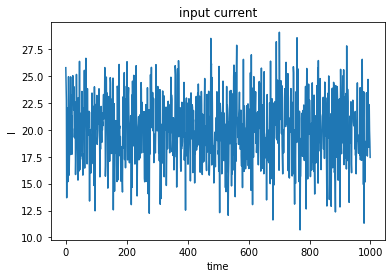

In [7]:
plt.plot(I_EXC_NOISE)
plt.xlabel("time")
plt.ylabel("I")
plt.title("input current")
plt.show()

# parameter setting

In [11]:
# U_INIT = torch.ones(EXC_SIZE) * -15.
# U_INIT[0] = -15.
EXC_PARAMS = {"c" : -65.0,
    "E_I" : I_EXC_NOISE,
    "a": 0.01,
    "b": 0.2,
    "d": 8,
    "dt": 0.5,
    "u": -8.,
    "v_rest": -65.,
}

INH_PARAMS = {"c" : -65.0,
    "E_I" : torch.zeros(size=(ITER, INH_SIZE)),
    "a": 0.02,
    "b": 0.2,
    "d": 8.,
    "dt": 0.5,
    "u": -8.,
    "v_rest": -65.,
}

# construct network, neuron group and synapse group

In [ ]:
net = Network()
ng_exc = NeuronGroup(
    net=net,
    size=EXC_SIZE,
    tag="exc_neurons",
    behavior={
        1: Izhikevich(**EXC_PARAMS),
        2: Izhikevich_input(),
        9: Recorder(["n.v", "torch.mean(n.v)", "n.I", "n.membrane_recovery"], auto_annotate=False),
        10: EventRecorder(["spikes"]),
    },
)

ng_inh = NeuronGroup(
    net=net,
    size=INH_SIZE,
    tag="inh_neurons",
    behavior={
        1: Izhikevich(**INH_PARAMS),
        2: Izhikevich_input(),
        9: Recorder(["n.v", "torch.mean(n.v)", "n.I", "n.membrane_recovery"], auto_annotate=False),
        10: EventRecorder(["spikes"]),
    },
)

SynapseGroup(src=ng_exc, dst=ng_exc, net=net, tag="GLUTAMATE")
# SynapseGroup(src=ng_exc, dst=ng_inh, net=net, tag="GLUTAMATE")
# SynapseGroup(src=ng_inh, dst=ng_exc, net=net, tag="GABA")

net.initialize()
net.simulate_iterations(ITER)

# plot spikes for the neuron(s)

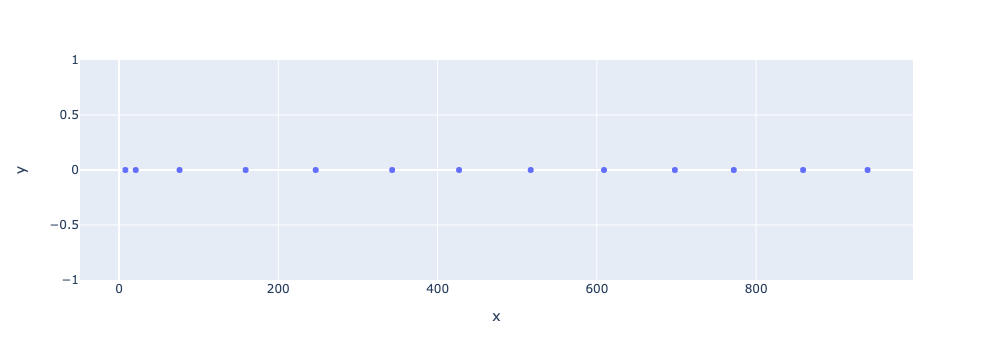

In [13]:
plotly.express.scatter(x=net['spikes.t',0], y=net['spikes.i',0]) 

# plot membrane potential using plotly

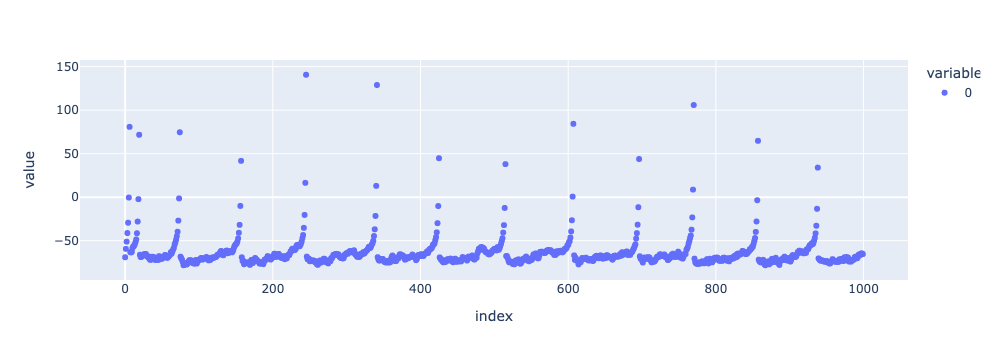

In [14]:
plotly.express.scatter(net["n.v",0][:, :1])

# plot membrane recovery variable using plotly

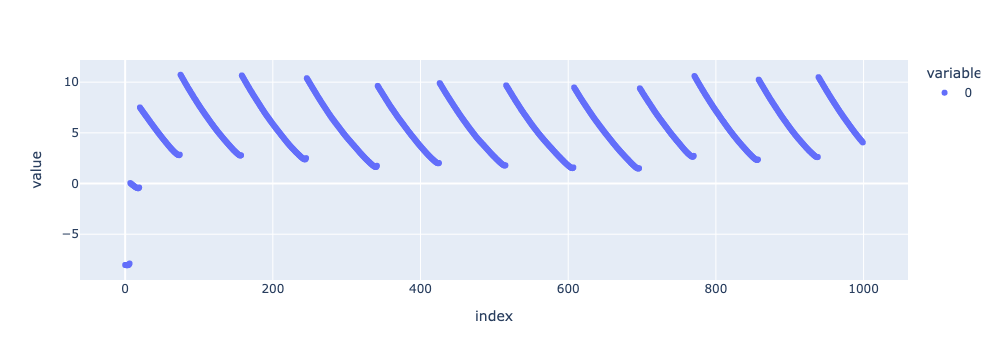

In [15]:
plotly.express.scatter(net['n.membrane_recovery',0][:, :1])

# plot membrane potential using matplotlib

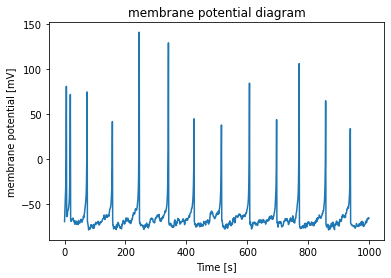

In [16]:
plt.plot(net['n.v',0][:, :1])
plt.ylabel("membrane potential [mV]")
plt.xlabel("Time [s]")
plt.title("membrane potential diagram")
plt.show()

# plot membrane recovery variable using matplotlib

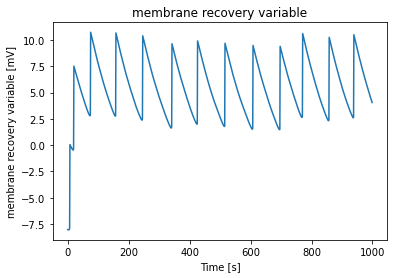

In [17]:
plt.plot(net['n.membrane_recovery', 0][:, :1])
plt.ylabel("membrane recovery variable [mV]")
plt.xlabel("Time [s]")
plt.title("membrane recovery variable")
plt.show()

# plot F_I_Curve diagram

In [ ]:
def F_I_Curve(a, b, c, d):
    I_EXC_STEP = torch.zeros(size=(ITER,EXC_SIZE))
    I_EXC_STEP[150:750,:] = 0.0
    n_config = {
        "c" : c,
        "E_I" : I_EXC_STEP,
        "a": a,
        "b": b,
        "d": d,
        "dt": 0.5,
        "u": -8.,
        "v_rest": -65.,}
    freqs = []
    for I in torch.arange(0.0, 40., 1.):
        I_EXC_STEP[150:750,:] = I
        n_config["E_I"] = I_EXC_STEP
        fi_net = Network()
        ng_exc = NeuronGroup(
            net=fi_net,
            size=1,
            behavior={
                1: Izhikevich(**n_config),
                2: Izhikevich_input(),
                9: EventRecorder(["spikes"]),
            },)
        SynapseGroup(src=ng_exc, dst=ng_exc, net=fi_net, tag="GLUTAMATE")
        fi_net.initialize()
        fi_net.simulate_iterations(ITER)
        freqs.append(fi_net['spikes.i',0].size()[0] / (750-150+1))
    
    plt.plot(freqs)
    plt.ylabel("f=1/T")
    plt.xlabel("I(t)")
    plt.title("Frequency Current Relation")
    plt.show()
    
F_I_Curve(0.1,0.05,-65,8)